# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**: MacKenzie Fountain

**ID**: 5362163

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [ ]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [2]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

In [ ]:
# Initialize the model
m = Model(HiGHS.Optimizer)

# Define decision variables
@variable(m, W11 >= 0)
@variable(m, W12 >= 0)
@variable(m, W13 >= 0)
@variable(m, W21 >= 0)
@variable(m, W22 >= 0)
@variable(m, W23 >= 0)
@variable(m, W31 >= 0)
@variable(m, W32 >= 0)
@variable(m, W33 >= 0)
@variable(m, Y[0:2], Bin)  # Binary variables
@variable(m, R21 >= 0)
@variable(m, R13 >= 0)
@variable(m, R23 >= 0)

# Define the objective function
@objective(m, Min, 
    82.5 * W11 + 75 * W21 + 90 * W31 +
    68 * W12 + 60.5 * W22 + 90.5 * W32 +
    57.5 * W13 + 72.5 * W23 + 69.5 * W33 +
    82.5 * R21 + 77 * R13 + 98 * R23 +
    2500 * Y[0] + 1500 * Y[1] + 2000 * Y[2]
)

# Add constraints
@constraint(m, W11 + W12 + W13 == 100)
@constraint(m, W21 + W22 + W23 == 90)
@constraint(m, W31 + W32 + W33 == 120)

@constraint(m, 0.16 * (W11 + W21 + R21) == R13)
@constraint(m, 0.30 * (W12 + W22) == R21 + R23)

@constraint(m, W11 + W21 + W31 + R21 <= 210)
@constraint(m, W12 + W22 + W32 <= 350)
@constraint(m, W13 + W23 + W33 + R23 + R13 <= 200)

# Logical constraints using big-M method
big_M = 1e6  # Adjust this value based on problem scale

@constraint(m, W11 + W21 + R21 <= big_M * (1 - Y[2]))
@constraint(m, W12 + W22 <= big_M * (1 - Y[2]))

# Ensure Y[2] is active
@constraint(m, Y[2] == 1)


In [13]:
optimize!(m)

Coefficient ranges:
  Matrix [2e-01, 1e+06]
  Cost   [6e+01, 2e+03]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+06]
Presolving model
1 rows, 2 cols, 2 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   24870           24870              0.00%        0      0      0         0     0.0s

Solving report
  Status            Optimal
  Primal bound      24870
  Dual bound        24870
  Gap               0% (tolerance: 0.01%)
  

In [16]:
print("
The Objective Value = ", objective_value(m))

# Initialize a matrix to store the values
W_values = zeros(3, 3)  # Adjust the dimensions as needed

# Populate the matrix with the optimized values
W_values[1, 1] = value(W11)
W_values[1, 2] = value(W12)
W_values[1, 3] = value(W13)
W_values[2, 1] = value(W21)
W_values[2, 2] = value(W22)
W_values[2, 3] = value(W23)
W_values[3, 1] = value(W31)
W_values[3, 2] = value(W32)
W_values[3, 3] = value(W33)

# Display the matrix
println("
Optimized W matrix:")
println(W_values)



The Objective Value = 24870.0
Optimized W matrix:
[0.0 0.0 100.0; 0.0 0.0 90.0; 110.0 0.0 10.0]


#### Discussion

MRF Facitlity will not be used. MRF is avoided due to its high total cost (tipping + recycling) compared to the other options. By using only LF and WTE, the plan avoids unnecessary recycling expenses.

![IMG_8546 2.jpeg](<attachment:IMG_8546 2.jpeg>)

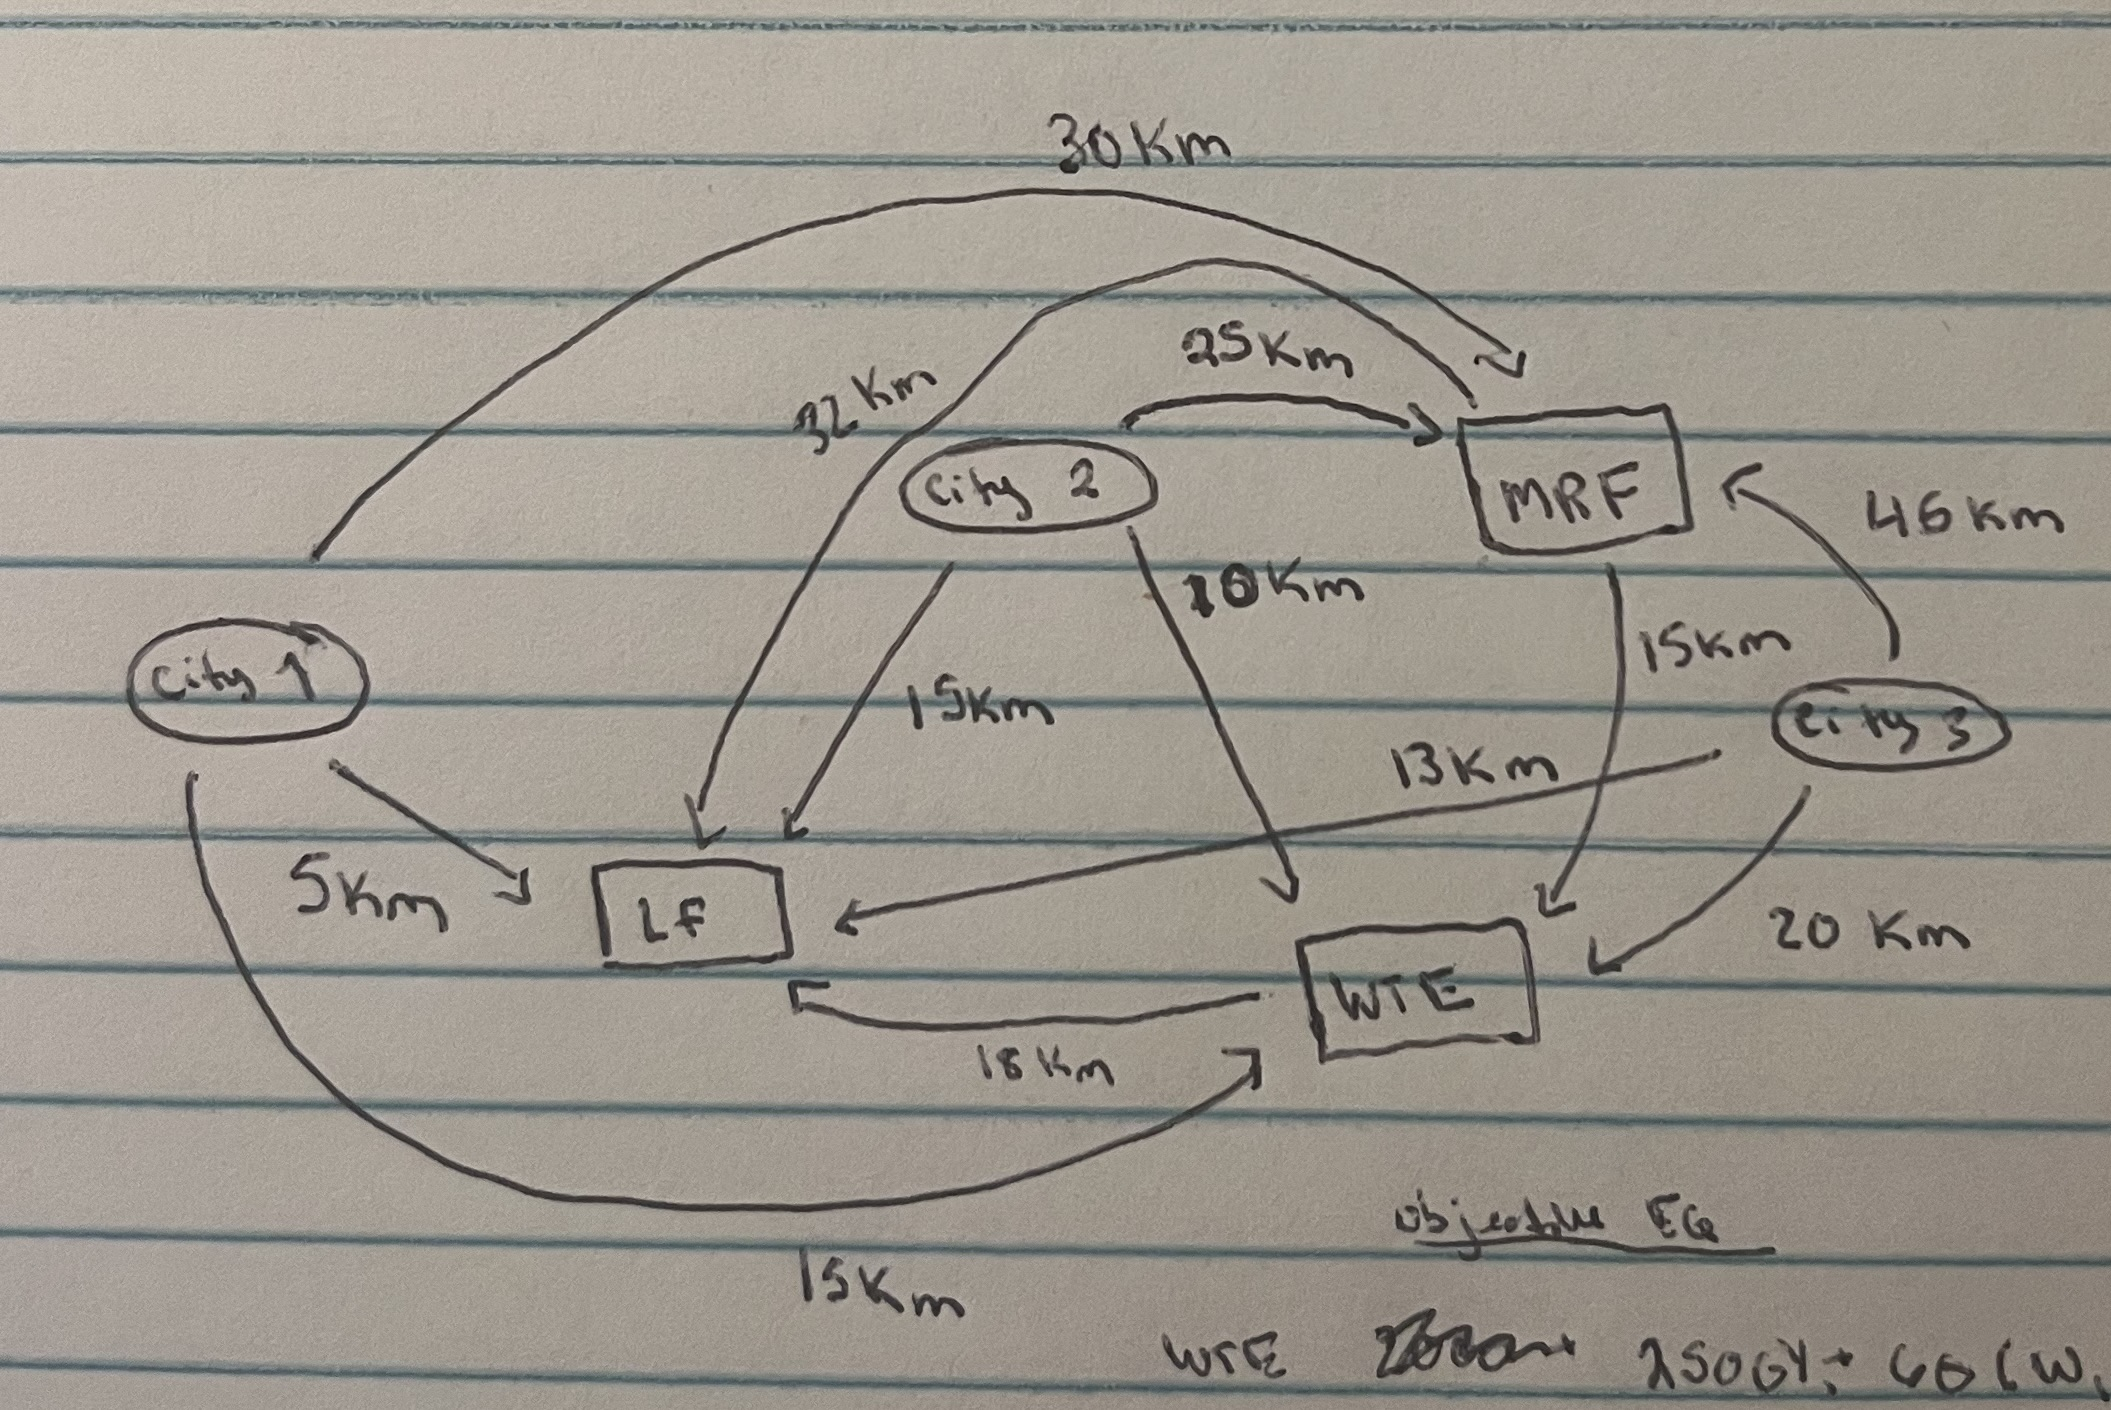

## References

* Chat GPT was used to debug the model's Big M constraint
* BEE 4750 Lecture 12